# Search for ICESat-2 tracks coincident with MOSAIC floe
This notebook presents a workflow for searching for and downloading ICESat-2 granules that are coincident with the Polarstern drift trajectory during the MOSAIC project. 

Currently it uses _ad-hoc_ python scripts as wrapper for the CMR API, in particular the `&circle` parameter for spatial searches.  In the (very near) future, this search capability will be added to `icepyx`.  Although the workflow has been developed to search for granules intersecting the Polarstern drift, it could be applied to buoys, flightlines, etc.  All that is needed is a file of points defining a trajectory. 

In [1]:
import sys
sys.path.append('../sunderseaice')  # Allow import of modules for sunderseaice

import os
import datetime as dt

import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import h5py
import xarray as xr

import download.nsidc_download as cmr


DATAPATH = '/home/apbarret/src/SunlightUnderSeaIce/data'

## Read Polarstern trajectory
I'm using a trajectory provided by Julienne Stroeve.

In [2]:
!file /home/apbarret/src/SunlightUnderSeaIce/data/pstrack.dat

/home/apbarret/src/SunlightUnderSeaIce/data/pstrack.dat: ISO-8859 text


In [3]:
!head /home/apbarret/src/SunlightUnderSeaIce/data/pstrack.dat

date time	SYS.STR.PosLat	SYS.STR.PosLon
	spot	spot
	�	�
2019/09/20 00:00:00	 	 
2019/09/20 01:00:00	 	 
2019/09/20 02:00:00	 	 
2019/09/20 03:00:00	 	 
2019/09/20 04:00:00	 	 
2019/09/20 05:00:00	 	 
2019/09/20 06:00:00	 	 


In [4]:
def read_pstrack(filepath):
    '''Reads Polarstern passage, cleans data and creates a pandas dataframe indexed by datetime'''
    df = pd.read_csv(filepath, encoding="ISO-8859-1", sep="\t", header=0, 
                 skiprows=[1,2], parse_dates=['date time'], index_col='date time')
    
    df.rename({"SYS.STR.PosLat": "Latitude", "SYS.STR.PosLon": "Longitude"}, axis="columns", inplace=True)
    df.index.name = "datetime"
    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.dropna()
    
    return df

In [5]:
filepath = os.path.join(DATAPATH, 'pstrack.dat')
track_hour_df = read_pstrack(filepath)

track_hour_df.head()

,Latitude,Longitude
datetime,,
2019-09-20 15:00:00,69.679548,18.996655
2019-09-20 16:00:00,69.679548,18.996648
2019-09-20 17:00:00,69.679545,18.996645
2019-09-20 18:00:00,69.679548,18.996640
2019-09-20 19:00:00,69.683804,19.025313


## Resampling to daily ship position

I use the `pandas` resampling tool to generate a _simple_ average daily position. This needs to be refined to deal with tracks that span the Prime Meridian and Time Line.  Fortunately, the Polarstern stays in one hemisphere in this example.  

In [6]:
track_day_df = track_hour_df.resample('D').mean()
track_day_df

,Latitude,Longitude
datetime,,
2019-09-20,69.833475,19.443211
2019-09-21,72.129731,26.278545
2019-09-22,75.288078,40.617453
2019-09-23,77.700268,58.798376
2019-09-24,80.292326,79.020890
...,...,...
2020-05-31,81.710422,9.821963
2020-06-01,81.333749,9.853240
2020-06-02,80.826408,9.754252


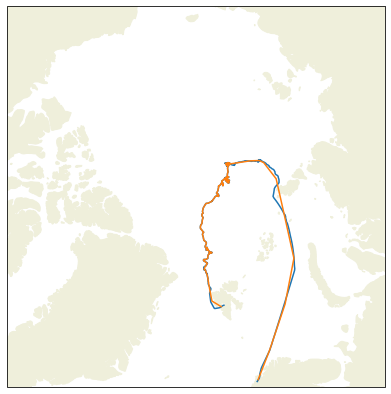

In [7]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 70., 90.], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.plot(track_hour_df["Longitude"], track_hour_df["Latitude"], transform=ccrs.PlateCarree())
ax.plot(track_day_df["Longitude"], track_day_df["Latitude"], transform=ccrs.PlateCarree())

From [Stefan Hendricks blog post](https://blogs.helmholtz.de/polarstern/en/2019/10/mapping-floes/), the Polarstern moored at the first floe on about 15 October 2019 and then cast off from the floe on 16 May 2020 to exchange personnel in Isfjord, Svalbard ([CIRES MOSAIC Blog](https://mosaic.colorado.edu/blog-rv-polarstern))

In [8]:
on_floe_track_df = track_day_df['2020-01-01':'2020-01-02']
on_floe_track_df

,Latitude,Longitude
datetime,,
2020-01-01,86.700445,117.877275
2020-01-02,86.821843,116.603774


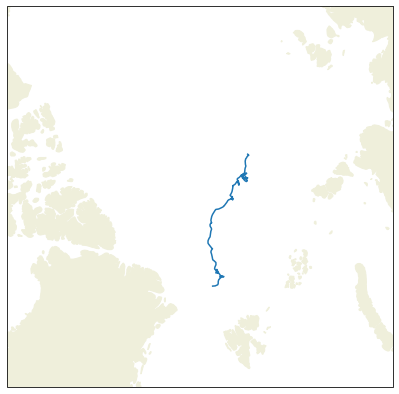

In [25]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180., 180., 75., 90.], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.plot(on_floe_track_df["Longitude"], on_floe_track_df["Latitude"], transform=ccrs.PlateCarree())

## Search for IS2 tracks within search radius

In [26]:
def _circle_params(df, search_radius = 1000.):
    '''Helper function to returns list of parameters for search circle'''
    latitude, longitude = df.values
    return [str(latitude), str(longitude), str(search_radius)]

def _bounding_box(df, search_box=0.5):
    '''Helper function to return bounding box'''
    latitude, longitude = df.values
    ll_lon = longitude - search_box/2.
    ll_lat = latitude - search_box/2.
    ur_lon = longitude + search_box/2.
    ur_lat = latitude + search_box/2.
    return '{0},{1},{2},{3}'.format(str(ll_lon), str(ll_lat), str(ur_lon), str(ur_lat))

In [27]:
product = 'ATL10'
version = '003'
search_date = '2019-10-15T12:00:00'
search_radius = 1000.

# Convert search_date to datetime object to allow easy programmatic calcuation of start and end dates 
search_datetime = dt.datetime.fromisoformat(search_date)
start_date, end_date = search_datetime - dt.timedelta(hours=12), search_datetime + dt.timedelta(hours=12)

# Will be added to icepyx very soon
results = cmr.cmr_search(
    product, 
    version, 
    start_date.isoformat(),  # CMR API expects iso format date strings
    end_date.isoformat(), 
    #circle=_circle_params(on_floe_track_df.loc[start_date.strftime('%Y-%m-%d'), :]),
    bounding_box = _bounding_box(on_floe_track_df.loc[start_date.strftime('%Y-%m-%d'), :])
)
results

Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=ATL10&version=003&version=03&version=3&temporal[]=2019-10-15T00:00:00,2019-10-16T00:00:00&bounding_box=134.0149647916667,84.51212366666665,134.5149647916667,85.01212366666665

Found 1 matches.


['https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL10.003/2019.10.15/ATL10-01_20191015021730_02780501_003_03.h5',
 'https://n5eil01u.ecs.nsidc.org/DP7/ATLAS/ATL10.003/2019.10.15/ATL10-01_20191015021730_02780501_003_03.iso.xml']

Download the granule

cmr.cmr_download(results[:1])

## Lets see what this looks like

In [28]:
def read_atl10(filepath):
    '''Read ATL10 (Freeboard)'''
    f = h5py.File(filepath, 'r')
    gt2l = xr.Dataset({
        'freeboard': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['beam_fb_height'][:]), 
        'geoseg_beg': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['geoseg_beg'][:]), 
        'geoseg_end': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['geoseg_end'][:]), 
        'latitude': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['latitude'][:]), 
        'longitude': (['x'], f['gt2l']['freeboard_beam_segment']['beam_freeboard']['longitude'][:])
    },)
    # Add segment center as alongtrack distance coordinate
    x = (gt2l.geoseg_beg + gt2l.geoseg_end.values) * 0.5
    gt2l.coords['x'] = x.values
    return gt2l

In [29]:
filepath = 'ATL10-01_20191015021730_02780501_003_03.h5'
gtl2 = read_atl10(filepath)
gtl2

<xarray.Dataset>
Dimensions:     (x: 96751)
Coordinates:
  * x           (x) float64 4.601e+05 4.601e+05 ... 5.501e+05 5.501e+05
Data variables:
    freeboard   (x) float32 3.4028235e+38 3.4028235e+38 ... 3.4028235e+38
    geoseg_beg  (x) int32 460089 460089 460089 460090 ... 550125 550127 550130
    geoseg_end  (x) int32 460093 460093 460093 460093 ... 550144 550146 550149
    latitude    (x) float64 82.44 82.44 82.44 82.44 ... 80.98 80.98 80.98 80.98
    longitude   (x) float64 -83.28 -83.28 -83.28 -83.28 ... 123.5 123.5 123.5

In [30]:
map_proj = ccrs.NorthPolarStereo()

polarstern_lat, polarstern_lon = on_floe_track_df.loc[start_date.strftime('%Y-%m-%d'), :].values

# Transform lat, lon to NorthPolarstereo x, y
mapcenter_x, mapcenter_y = map_proj.transform_point(polarstern_lon, polarstern_lat, ccrs.PlateCarree())

polarstern_track = map_proj.transform_points(ccrs.PlateCarree(), on_floe_track_df["Longitude"].values, on_floe_track_df["Latitude"].values)
polarstern_track_x, polarstern_track_y = polarstern_track[:,0], polarstern_track[:,1]

is2_path = map_proj.transform_points(ccrs.PlateCarree(), gtl2.longitude.values, gtl2.latitude.values)
is2_path_x, is2_path_y = is2_path[:,0], is2_path[:,1]

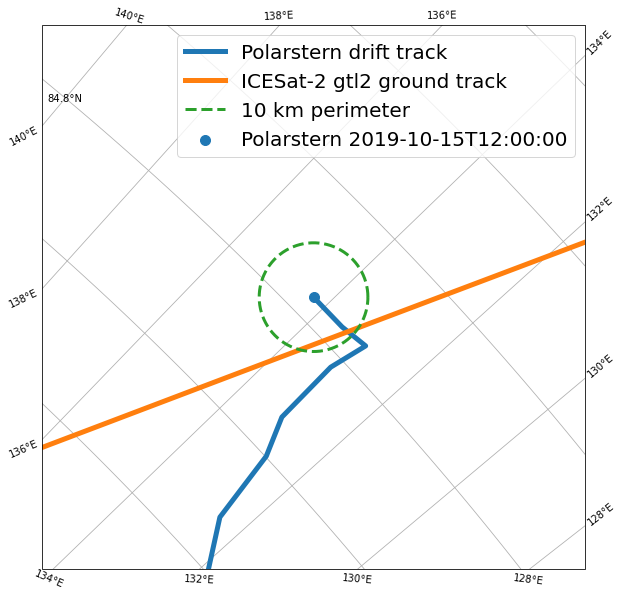

In [31]:
dx, dy = 50000., 50000.

# compute circle centered on Polarstern for plotting
r = 10000
theta = np.linspace(0.,360.,360) * np.pi / 180.
x1 = mapcenter_x + r*np.cos(theta)
y1 = mapcenter_y + r*np.sin(theta)
#rx, ry = 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=map_proj)
ax.set_extent([mapcenter_x-dx, mapcenter_x+dx, mapcenter_y-dy, mapcenter_y+dy], map_proj)
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True)

ax.scatter([mapcenter_x], [mapcenter_y], 100, transform=map_proj, label='Polarstern {0}'.format(search_date))
ax.plot(polarstern_track_x, polarstern_track_y, lw=5, transform=map_proj, label='Polarstern drift track')
ax.plot(is2_path_x, is2_path_y, lw=5, transform=map_proj, label='ICESat-2 gtl2 ground track')
ax.plot(x1, y1, lw=3, ls='--', transform=map_proj, label='10 km perimeter')
ax.legend(fontsize=20)